# Progetto Finale di Introduzione alla Data Science
Autore: **Lorenzo La Corte** - S4784539

Dataset: **Google Play Store Apps**

--------------------------------------------------------------------------------------------------------------------

## Gradimento delle App Gratuite o a Pagamento

**Obiettivo dell'analisi:**
Studiare le criticità e i punti di forza di app a pagamento e di app gratuite con pubblicità.


**Nel dettaglio:**
Cerco con questa analisi di capire se è possibile che il prezzo di un'applicazione influenzi la valutazione e il numero di recensioni.

Immagino infatti che l'acquirente di un'app a pagamento sia piu' stimolato a lasciare una recensione, per comunicare agli altri se il prodotto valga o meno la spesa.

Inoltre credo che l'acquirente di un'applicazione a pagamento **scadente** sia molto piu' propenso a lasciarne una recensione negativa; al contrario penso che un'app deludente ma gratuita sarà probabilmente solo disinstallata. 

Allo stesso tempo per monetizzare app gratuite sono necessarie **pubblicità**; se queste sono troppe o troppo invasive penso che possano portare a rating negativi.


**Ipotesi:**
Le ipotesi sono quindi che:
1. - le app gratuite siano piu' gradite in generale delle app a pagamento.
2. - in proporzione alle installazioni, le app a pagamento siano piu' recensite di quelle gratuite.
3. - le pubblicità troppo invasive portino a recensioni negative.


--------------------------------------------------------------------------------------------------------------------

## Indice

* [0.) Operazioni Preliminari](#0)


* [1.) Analisi su Rating di App Gratuite o a Pagamento](#1)
* [2.) Analisi su Installazioni e Recensioni di App Gratuite o a Pagamento](#2)
* [3.) Correlazione tra Pubblicità nelle App e Recensioni Negative](#3)


* [4.) Conclusioni Riguardo all'Analisi](#4)


* [5.) Predizione dei Sentimenti dalle Recensioni (Apprendimento Supervisionato)](#5)   

* [6.) Predizione dei Sentimenti dalle Recensioni (Metodo Manuale)](#6)   

## Operazioni Preliminari <a id='0'></a>

Importo le librerie di base:

In [114]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import scipy.stats as stats
# !pip install scipy==1.7.0
import scipy

Importo il dataset e ne visualizzo le prime righe:

In [115]:
playstore = pd.read_csv('googleplaystore.csv')
playstore.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Visualizzo numero di righe e di caratteristiche:

In [116]:
print("(Numero di Righe, Numero di Colonne): " + str(playstore.shape))
righe_iniziali = playstore.shape[0] # salvo per dopo le righe prima della pulizia

(Numero di Righe, Numero di Colonne): (10841, 13)


## Pulizia del Dataset 

Una veloce analisi del dataset mi porta a pensare che le caratteristiche quantitive siano:
- Rating,
- Reviews,
- Size,
- Installs,
- Price.

Utilizzo il metodo *describe()* e noto che esso **mi restituisce solo Rating come variabile quantitativa**.

In [117]:
playstore.describe() # mi dovrebbe restituire solo le caratteristiche quantitative

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


Probabilmente devo **pulire il dataset** per rendere 'Reviews', 'Size', 'Installs', 'Price' quantitative.

Quindi:
- A) Gestire eventuali valori nulli,
- B) Convertire Reviews, Installs e Price a quantitative,
- C) Eliminazione dei duplicati.

Anche la **Size** risulta non quantitativa: la colonna è composta da stringhe; in questo caso **non gestisco questa caratteristica in quanto non mi sembra utile alle analisi**; gestisco invece le altre caratteristiche.

## Gestione dei Valori Nulli

Conto nel dataset tutte le **occorrenze nulle**:

In [118]:
playstore.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

Prendiamo in considerazione quindi la colonna **Rating**. Abbiamo due soluzioni:
1. Provare a completare le righe con elementi nulli, in questo caso con la media degli altri valori del dataset, 
2. Eliminare le righe con elementi nulli.

Adottiamo la prima soluzione per la colonna **Rating**, mentre eliminamo le altre righe con occorrenze nulle per altre caratteristiche, che dovrebbero essere molto poche.

In [119]:
# Soluzione 1 (per Rating)
average_rating = playstore['Rating'].mean()
playstore['Rating'].fillna(average_rating, inplace = True) # completa i mancanti con la media degli altri

# Soluzione 2 (per i pochi altri valori nulli)
playstore.dropna(how ='any', inplace = True)

# Risultato
print(playstore.isnull().sum())
print("Numero di Righe Rimaste: " + str(playstore.shape[0]))

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64
Numero di Righe Rimaste: 10829


Ho quindi rimosso tutti i valori nulli dal dataset eliminando pochissime righe, cercando di mantenere piu' informazione possibile.

## Gestione delle Variabili Quantitative
Analizzo ora le feature Installs, Reviews, Price e Type; esse **dovrebbero essere quantitative ma non lo sono**.

Guardo quindi il loro tipo:

In [120]:
print("Tipo di Installs:\t" + str(type(playstore['Installs'][0])))
print("Tipo di Reviews:\t" + str(type(playstore['Reviews'][0])))
print("Tipo di Price:\t\t" + str(type(playstore['Price'][0])))
print("Tipo di Type:\t\t" + str(type(playstore['Type'][0])))

Tipo di Installs:	<class 'str'>
Tipo di Reviews:	<class 'str'>
Tipo di Price:		<class 'str'>
Tipo di Type:		<class 'str'>


--------------------------------------------------------------------------------------------------

Per trasformare Installs in quantitativa ho analizzato i suoi valori e **rimosso ciò che rendeva questa caratteristica una stringa**, ovvero caratteri e valori particolari, per poi fare una conversione ad un tipo numerico:

In [121]:
if(type(playstore['Installs'][0]) is str):
    playstore = playstore[playstore.Installs != "Free"] # rimuovo le righe con questo valore per Installs
    playstore['Installs'] = [float(x.replace("+","").replace(",",".").replace(".","")) for x in playstore['Installs']]
    
playstore.describe()

,Rating,Installs
count,10829.000000,1.082900e+04
mean,4.192041,1.547990e+07
std,0.479038,8.507114e+07
min,1.000000,0.000000e+00
25%,4.100000,5.000000e+03
50%,4.200000,1.000000e+05
75%,4.500000,5.000000e+06
max,5.000000,1.000000e+09


Effettuo quindi la stessa operazione sulle altre caratteristiche, al fine di renderle quantitative:

In [122]:
if(type(playstore['Reviews'][0]) is str):
    playstore['Reviews'] = [float(x.replace("M","000000")) for x in playstore['Reviews']]

if(type(playstore['Price'][0]) is str):
    playstore = playstore[playstore.Price != "Everyone"] # rimuovo le righe con questo valore per Price
    playstore['Price'] = [float(x.replace("$","")) for x in playstore['Price']]

if(type(playstore['Type'][0]) is str):
    playstore['Type'] = [int(x.replace("Free","0").replace("Paid","1")) for x in playstore['Type']]

playstore.describe()

,Rating,Reviews,Installs,Type,Price
count,10829.000000,1.082900e+04,1.082900e+04,10829.000000,10829.000000
mean,4.192041,4.446018e+05,1.547990e+07,0.073599,1.028091
std,0.479038,2.929213e+06,8.507114e+07,0.261129,15.957778
min,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,4.100000,3.800000e+01,5.000000e+03,0.000000,0.000000
50%,4.200000,2.100000e+03,1.000000e+05,0.000000,0.000000
75%,4.500000,5.481500e+04,5.000000e+06,0.000000,0.000000
max,5.000000,7.815831e+07,1.000000e+09,1.000000,400.000000


Ne ho approfittato per **rendere anche Type quantitativa**, in particolare: 

- le **App Gratuite** avranno come valore **0**,
- le **App a Pagamento** avranno come valore **1**.

## Elimazione Duplicati
Infine, guardo se ci sono duplicati nel dataset e nel caso li rimuovo.

Inizio osservando tutte le applicazioni che risultano duplicate:

In [123]:
playstore[playstore.duplicated(['App'])]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
229,Quick PDF Scanner + OCR FREE,BUSINESS,4.2,80805.0,Varies with device,5000000.0,0,0.0,Everyone,Business,"February 26, 2018",Varies with device,4.0.3 and up
236,Box,BUSINESS,4.2,159872.0,Varies with device,10000000.0,0,0.0,Everyone,Business,"July 31, 2018",Varies with device,Varies with device
239,Google My Business,BUSINESS,4.4,70991.0,Varies with device,5000000.0,0,0.0,Everyone,Business,"July 24, 2018",2.19.0.204537701,4.4 and up
256,ZOOM Cloud Meetings,BUSINESS,4.4,31614.0,37M,10000000.0,0,0.0,Everyone,Business,"July 20, 2018",4.1.28165.0716,4.0 and up
261,join.me - Simple Meetings,BUSINESS,4.0,6989.0,Varies with device,1000000.0,0,0.0,Everyone,Business,"July 16, 2018",4.3.0.508,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10715,FarmersOnly Dating,DATING,3.0,1145.0,1.4M,100000.0,0,0.0,Mature 17+,Dating,"February 25, 2016",2.2,4.0 and up
10720,Firefox Focus: The privacy browser,COMMUNICATION,4.4,36981.0,4.0M,1000000.0,0,0.0,Everyone,Communication,"July 6, 2018",5.2,5.0 and up
10730,FP Notebook,MEDICAL,4.5,410.0,60M,50000.0,0,0.0,Everyone,Medical,"March 24, 2018",2.1.0.372,4.4 and up
10753,Slickdeals: Coupons & Shopping,SHOPPING,4.5,33599.0,12M,1000000.0,0,0.0,Everyone,Shopping,"July 30, 2018",3.9,4.4 and up


Sembrano essere molte; ne analizzo una:

In [124]:
playstore[playstore['App']=="ZOOM Cloud Meetings"]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
213,ZOOM Cloud Meetings,BUSINESS,4.4,31614.0,37M,10000000.0,0,0.0,Everyone,Business,"July 20, 2018",4.1.28165.0716,4.0 and up
256,ZOOM Cloud Meetings,BUSINESS,4.4,31614.0,37M,10000000.0,0,0.0,Everyone,Business,"July 20, 2018",4.1.28165.0716,4.0 and up


E scopro che effettivamente lo è; **elimino quindi tutti i duplicati presenti nel dataset**.

In [125]:
playstore = playstore.drop_duplicates(keep='last',subset=['App'])

Guardo ora il dataset:

In [126]:
print("Numero di Righe Rimaste: " + str(playstore.shape[0]))

print("\nHo rimosso: " + str(righe_iniziali - playstore.shape[0]) + " righe, ovvero l'" + str("{:.2f}".format((righe_iniziali - playstore.shape[0])/righe_iniziali*100)) + "% del totale.")

print("\n\nCaratteristiche Quantitative a Disposizione:")
playstore.describe()

Numero di Righe Rimaste: 9648

Ho rimosso: 1193 righe, ovvero l'11.00% del totale.


Caratteristiche Quantitative a Disposizione:


,Rating,Reviews,Installs,Type,Price
count,9648.000000,9.648000e+03,9.648000e+03,9648.000000,9648.000000
mean,4.176325,2.168957e+05,7.802970e+06,0.077840,1.098122
std,0.494198,1.831767e+06,5.379994e+07,0.267933,16.861193
min,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,4.000000,2.500000e+01,1.000000e+03,0.000000,0.000000
50%,4.200000,9.740000e+02,1.000000e+05,0.000000,0.000000
75%,4.500000,2.944925e+04,1.000000e+06,0.000000,0.000000
max,5.000000,7.812821e+07,1.000000e+09,1.000000,400.000000


I valori del dataset ora hanno un senso e il dataset è pulito e ordinato: siamo pronti ad una prima analisi delle feature.

# Analisi delle Feature

Cerchiamo di analizzare alcune features, per estrapolare interessanti informazioni su di esse e le loro correlazioni. 

Andiamo inanzitutto a dare un'occhiata alla tabella delle correlazioni:

In [127]:
playstore.corr().style.background_gradient(cmap="Blues")

,Rating,Reviews,Installs,Type,Price
Rating,1.000000,0.054332,0.039240,0.042410,-0.019331
Reviews,0.054332,1.000000,0.625023,-0.033011,-0.007594
Installs,0.039240,0.625023,1.000000,-0.041728,-0.009414
Type,0.042410,-0.033011,-0.041728,1.000000,0.224175
Price,-0.019331,-0.007594,-0.009414,0.224175,1.000000


Notiamo:
- una **correlazione positiva tra Reviews e Installs** e 
- una **leggera correlazione positiva tra Prezzo e Tipo dell'applicazione** (gratuita o a pagamento).

# 1. Analisi su Rating di App Gratuite o a Pagamento <a id='1'></a>
**Ipotesi:** le app gratuite sono piu' gradite in generale delle app a pagamento.

In questa prima analisi ci concentriamo principalmente sulle feature Rating e Price, pondendoci 3 domande:

1. Qual'è la distribuzione dei Rating?

2. Qual'è la percentuale di app a pagamento e app gratuite?

3. T-Test: le app gratuite sono piu' gradite di quelle a pagamento?

## 1.1. Qual'è la distribuzione dei Rating?

<AxesSubplot:>

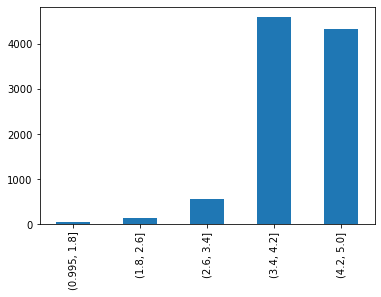

In [128]:
Ratings = playstore['Rating']
Ratings = Ratings.value_counts(bins=5, sort=False) # divido in 20 classi di prezzo 
Ratings.plot(kind = 'bar')

Notiamo che **la maggior parte delle valutazioni degli utenti sono positive**.

-------------------------------------------------------------------------------

## 1.2. Percentuale di App a Pagamento e Gratuite.

In [146]:
free_apps = playstore[playstore['Type']==0]
paid_apps = playstore[playstore['Type']==1]

perc_app_gratis = len(free_apps) / playstore.shape[0]
perc_app_pagate = len(paid_apps) / playstore.shape[0]

print("Percentuale di app gratis: " + str(perc_app_gratis))
print("Percentuale di app a pagamento: " + str(perc_app_pagate))

Percentuale di app gratis: 0.9230849076188499
Percentuale di app a pagamento: 0.07691509238115009


Osserviamo che **la maggior parte delle applicazioni sono gratuite**.

## 1.3. T-Test: le app gratuite sono piu' gradite di quelle a pagamento?

Formuliamo ora un'ipotesi circa il gradimento di app gratuite e a pagamento, usando la seguente notazione:

H0 = "il gradimento delle app gratuite è maggiore del gradimento delle app a pagamento". 

A questo punto l'ipotesi alternativa è:

HA = "il gradimento delle app gratuite è minore del gradimento delle app a pagamento". 

Usiamo un **t-test a una coda** per verificare se l'ipotesi nulla è corretta.

Sappiamo che si devono verificare alcune ipotesi:
1. Campione con numero di elementi n > 30: **considero un campione di 500 elementi**;
2. Popolazione N almeno dieci volte superiore al campione: **N = 9634 > 10\*500**

In [130]:
campione = free_apps['Rating'].sample(n = 500) # prendo un campione di 500 app scelte casualmente
print("Grandezza campione:\t\t\t\t " + str(campione.shape[0]))
print("Media sul campione di app gratuite:\t\t " + str(np.mean(campione)))

popolazione_pagamento = paid_apps['Rating']
print("\nPopolazione delle app a pagamento:\t\t " + str(popolazione_pagamento.shape[0]))
print("Media sulla popolazione di app a pagamento:\t " + str(np.mean(popolazione_pagamento)))

Grandezza campione:				 500
Media sul campione di app gratuite:		 4.167120657627849

Popolazione delle app a pagamento:		 751
Media sulla popolazione di app a pagamento:	 4.248460833048903


Le due condizioni sono verificate; eseguiamo quindi il t-test usando la libreria scipy. 

Scegliamo un livello di confidenza pari a 95%: il livello di significatività è 0.05.

In [131]:
t_statistic, p_value = stats.ttest_1samp(a= campione, popmean= popolazione_pagamento.mean(),alternative='less')
print("Eseguo un test sulle app gratuite con media dei Rating maggiore (poiché alternative è less) della media delle app a pagamento.")
print("Statistica del Test: " + str(t_statistic))
print("p-value calcolato: " + str(p_value))

Eseguo un test sulle app gratuite con media dei Rating maggiore (poiché alternative è less) della media delle app a pagamento.
Statistica del Test: -3.715409958743413
p-value calcolato: 0.00011290164641652233


***p-value < livello di significatività***

H0 è quindi rigettata, mentre accettiamo HA;
quindi **il gradimento delle app gratuite è minore del gradimento delle app a pagamento**.

L'ipotesi iniziale è quindi errata ed abbiamo scoperto che le app a pagamento in generale hanno un maggiore gradimento. 

# 2. Analisi su Installazioni e Recensioni di App Gratuite o a Pagamento. <a id='2'></a>

**Ipotesi:** In proporzione alle installazioni, le app a pagamento sono piu' recensite di quelle a pagamento.

Creo una colonna che indica il **rapporto tra numero di recensioni e numero di installazioni**.

In [132]:
rew_ratio_values = playstore["Reviews"].div(playstore["Installs"])
playstore["Review Ratio"] = rew_ratio_values
playstore.dropna(how ='any', inplace = True)

In [133]:
playstore.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Review Ratio
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19M,10000.0,0,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,0.015900
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,8.7M,5000000.0,0,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,0.017502
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644.0,25M,50000000.0,0,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,0.004313
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967.0,2.8M,100000.0,0,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,0.009670
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167.0,5.6M,50000.0,0,0.0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up,0.003340


## 2.1. T-Test: le app gratutie hanno un Review Ratio piu' basso di quelle a pagamento?

Formuliamo ora un'ipotesi circa il gradimento di app gratuite e a pagamento, usando la seguente notazione:

H0 = "le app gratuite hanno un rapporto Review/Installazioni piu' basso di quelle gratuite". 

A questo punto l'ipotesi alternativa è:

HA = "le app a pagamento hanno un rapporto Review/Installazioni piu' basso di quelle gratuite". 

Usiamo un **t-test a una coda** per verificare se l'ipotesi nulla è corretta.

Sappiamo che si devono verificare alcune ipotesi:
1. Campione con numero di elementi n > 30: **considero un campione di 500 elementi**;
2. Popolazione N almeno dieci volte superiore al campione: **N = 9634 > 10\*500**

In [134]:
free_apps = playstore[playstore['Price']==0]
paid_apps = playstore[playstore['Price']>0]

perc_app_gratis = len(free_apps) / playstore.shape[0]
perc_app_pagate = len(paid_apps) / playstore.shape[0]

print("Percentuale di app gratis: \t " + str(perc_app_gratis))
print("Percentuale di app a pagamento:\t " + str(perc_app_pagate))

print("\nGrandezza dataset: " + str(playstore.shape[0]))
print("Media del Review Ratio per le app gratuite: \t " + str(free_apps['Review Ratio'].mean()))
print("Media del Review Ratio per le app a pagamento: \t " + str(paid_apps['Review Ratio'].mean()))

campione = free_apps['Review Ratio'].sample(n = 500)
print("\nGrandezza del campione di app gratuite:\t\t " + str(campione.shape[0]))
print("Media sul campione di app gratuite:\t\t " + str(np.mean(campione)))

popolazione_restante = paid_apps['Review Ratio']
print("Popolazione di app a pagamento:\t\t\t " + str(popolazione_restante.shape[0]))
print("Media sulla popolazione di app a pagamento: \t" + str(np.mean(popolazione_restante)))

print("\n\nEseguo un t-test su app gratuite con ratio minore (poiché alternative è greater) di quelle a pagamento:")
t_statistic, p_value = stats.ttest_1samp(a= campione, popmean= popolazione_restante.mean(),alternative='greater')
print("Statistica del Test: " + str(t_statistic))
print("p-value calcolato: " + str(p_value))

Percentuale di app gratis: 	 0.9230849076188499
Percentuale di app a pagamento:	 0.07691509238115009

Grandezza dataset: 9634
Media del Review Ratio per le app gratuite: 	 0.03211026203969388
Media del Review Ratio per le app a pagamento: 	 0.11017516437246958

Grandezza del campione di app gratuite:		 500
Media sul campione di app gratuite:		 0.03721385198799999
Popolazione di app a pagamento:			 741
Media sulla popolazione di app a pagamento: 	0.11017516437246958


Eseguo un t-test su app gratuite con ratio minore (poiché alternative è greater) di quelle a pagamento:
Statistica del Test: -8.928715803066384
p-value calcolato: 1.0


Abbiamo considerato un campione di 500 app gratuite, e di 741 app a pagamento. 

Le condizioni del t-test sono quindi verificate, come descritto in precedenza, ed il risultato è che:

***p-value > livello di significatività***

H0 è quindi accettata, quindi **le app gratutie hanno un rapporto Review/Installazioni piu' basso di quelle a pagamento**.

L'ipotesi iniziale è quindi verificata: **le app a pagamento sono piu' recensite in rapporto al numero delle installazioni**.

# 3. Correlazione tra Pubblicità nelle App e Recensioni Negative <a id='3'></a>

**Ipotesi:** le pubblicità troppo invasive portano a recensioni negative.

**Nota Importante:** nel dataset non ho la valutazione della singola recensione ma solo un'indicazione sul suo sentimento generale; l'analisi quindi non è del tutto centrata con l'ipotesi iniziale ma cerca di riprenderne il concetto chiave.

Vado ora ad effettuare un analisi sulla **pubblicità** nelle applicazioni, ed in particolare al fatto che essa **possa portare a recensioni negative**.

Osservo quindi se una data recensione contiene parole inerenti alle pubblicità: se le contiene mi aspetto che la recensione sia negativa.

---------------------------------------------------------------------------------

## 3.1. Trasformazione del Dataset per l'Analisi
Inizio **facendo un *join* tra il dataset delle recensioni e quello generale**:

In [135]:
ps_reviews = pd.read_csv('googleplaystore_user_reviews.csv') #importo il file

playstore_with_rew = playstore.join(ps_reviews.set_index('App'), on='App')
playstore_with_rew.dropna(how ='any', inplace = True)

playstore_with_rew.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Review Ratio,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791.0,33M,1000000.0,0,0.0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up,0.013791,It's...a coloring book ap. And I like adult co...,Positive,2.166667e-01,0.573810
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791.0,33M,1000000.0,0,0.0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up,0.013791,wanted access pictures. I denied let app. Don'...,Neutral,0.000000e+00,0.000000
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791.0,33M,1000000.0,0,0.0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up,0.013791,Way many ads... im paying 8$USD pictures color...,Positive,3.000000e-01,0.600000
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791.0,33M,1000000.0,0,0.0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up,0.013791,"good bad color outside lines. like real, tradi...",Positive,2.775558e-17,0.579167
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791.0,33M,1000000.0,0,0.0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up,0.013791,I really enjoying application. My complaint sm...,Negative,-3.472222e-02,0.581944


---------------------------------------------------------------------------------

**Trasformo Sentiment in caratteristica quantitativa**, convertendo:
- Positive in 1,
- Neutral in 0.5,
- Negative in 0.

In [136]:
playstore_with_rew['Sentiment'] = [float(x.replace("Positive","1").replace("Neutral","0.5").replace("Negative","0")) for x in playstore_with_rew['Sentiment']]
    
playstore_with_rew.describe()

,Rating,Reviews,Installs,Type,Price,Review Ratio,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
count,35929.000000,3.592900e+04,3.592900e+04,35929.000000,35929.000000,35929.000000,35929.000000,35929.000000,35929.000000
mean,4.297261,1.413317e+06,4.375691e+07,0.011578,0.109197,0.032909,0.709691,0.180904,0.493767
std,0.302842,5.731737e+06,1.453465e+08,0.106980,1.302471,0.041932,0.415067,0.350080,0.258053
min,2.600000,4.600000e+01,1.000000e+03,0.000000,0.000000,0.000289,0.000000,-1.000000,0.000000
25%,4.100000,1.024700e+04,1.000000e+06,0.000000,0.000000,0.010375,0.500000,0.000000,0.361111
50%,4.300000,6.362400e+04,5.000000e+06,0.000000,0.000000,0.020846,1.000000,0.150000,0.514835
75%,4.500000,5.152400e+05,1.000000e+07,0.000000,0.000000,0.037815,1.000000,0.400000,0.650000
max,4.900000,7.812821e+07,1.000000e+09,1.000000,29.990000,0.448814,1.000000,1.000000,1.000000


---------------------------------------------------------------------------------

Creo quindi una **nuova caratteristica**, che **ha valore 1 se la recensione contiene una parola inerente alla pubblicità**.

In [138]:
words = ["ad", "ads", "advert", "advertising", "publicity"]

# riempio la colonna di zeri
playstore_with_rew['Complains_Adv'] = [0] * playstore_with_rew.shape[0]

# inserisco 1 se la recensione contiene una delle parole indicate
for i, row in playstore_with_rew.iterrows():

    isPresent = 0

    for word in words:
        if word in str(row['Translated_Review']).split():
            isPresent = 1
            # print("\n" + str(row['Translated_Review']) + "\n" + str(row['Sentiment']) + "\n")

    playstore_with_rew.loc[i, "Complains_Adv"] = isPresent
    
playstore_with_rew['Complains_Adv'] = [int(x) for x in playstore_with_rew['Complains_Adv']]
    
playstore_with_rew.describe()

,Rating,Reviews,Installs,Type,Price,Review Ratio,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Complains_Adv
count,35929.000000,3.592900e+04,3.592900e+04,35929.000000,35929.000000,35929.000000,35929.000000,35929.000000,35929.000000,35929.000000
mean,4.297261,1.413317e+06,4.375691e+07,0.011578,0.109197,0.032909,0.709691,0.180904,0.493767,0.041471
std,0.302842,5.731737e+06,1.453465e+08,0.106980,1.302471,0.041932,0.415067,0.350080,0.258053,0.199379
min,2.600000,4.600000e+01,1.000000e+03,0.000000,0.000000,0.000289,0.000000,-1.000000,0.000000,0.000000
25%,4.100000,1.024700e+04,1.000000e+06,0.000000,0.000000,0.010375,0.500000,0.000000,0.361111,0.000000
50%,4.300000,6.362400e+04,5.000000e+06,0.000000,0.000000,0.020846,1.000000,0.150000,0.514835,0.000000
75%,4.500000,5.152400e+05,1.000000e+07,0.000000,0.000000,0.037815,1.000000,0.400000,0.650000,0.000000
max,4.900000,7.812821e+07,1.000000e+09,1.000000,29.990000,0.448814,1.000000,1.000000,1.000000,1.000000


Notiamo che **il 4% circa delle recensioni parlano di pubblicità**.


## 3.2 Correlazione tra Pubblicità e Rating
Cerco di vedere quindi se ci sia una correlazione tra pubblicità e rating:

In [143]:
playstore_with_rew.corr().style.background_gradient(cmap="Blues")

,Rating,Reviews,Installs,Type,Price,Review Ratio,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Complains_Adv
Rating,1.000000,0.075785,0.019964,0.008883,-0.010083,0.286071,0.091491,0.093348,0.068765,-0.030387
Reviews,0.075785,1.000000,0.564232,-0.026381,-0.020592,0.313742,-0.071745,-0.080049,-0.009319,-0.034826
Installs,0.019964,0.564232,1.000000,-0.032436,-0.025201,-0.004381,-0.042383,-0.057868,-0.006320,-0.023467
Type,0.008883,-0.026381,-0.032436,1.000000,0.774633,0.260697,0.027435,0.014730,0.007334,-0.022512
Price,-0.010083,-0.020592,-0.025201,0.774633,1.000000,0.192184,0.025730,0.024148,0.003182,-0.017439
Review Ratio,0.286071,0.313742,-0.004381,0.260697,0.192184,1.000000,-0.009726,-0.045599,0.031601,-0.064764
Sentiment,0.091491,-0.071745,-0.042383,0.027435,0.025730,-0.009726,1.000000,0.751681,0.176329,0.003888
Sentiment_Polarity,0.093348,-0.080049,-0.057868,0.014730,0.024148,-0.045599,0.751681,1.000000,0.259668,-0.024217
Sentiment_Subjectivity,0.068765,-0.009319,-0.006320,0.007334,0.003182,0.031601,0.176329,0.259668,1.000000,0.000654
Complains_Adv,-0.030387,-0.034826,-0.023467,-0.022512,-0.017439,-0.064764,0.003888,-0.024217,0.000654,1.000000


Notiamo che **non c'è correlazione tra Sentiment e Complains_Adv**.

---------------------------------------------------------------------------------

Per confermarlo analizzo le distribuzioni dei Sentimenti sulle recensioni che parlano di pubblicità e delle recensioni in generale.

In [144]:
complains_adv = playstore_with_rew[playstore_with_rew['Complains_Adv']==1]

s_negative = playstore_with_rew[playstore_with_rew['Sentiment']==0]
s_neutral = playstore_with_rew[playstore_with_rew['Sentiment']==0.5]
s_positive = playstore_with_rew[playstore_with_rew['Sentiment']==1]

s_negative_add = complains_adv[complains_adv['Sentiment']==0]
s_neutral_add = complains_adv[complains_adv['Sentiment']==0.5]
s_positive_add = complains_adv[complains_adv['Sentiment']==1]

print("Sentimento Negativo sul Totale: " + str(len(s_negative)/playstore_with_rew.shape[0]*100) + "%")
print("Sentimento Neutrale sul Totale: " + str(len(s_neutral)/playstore_with_rew.shape[0]*100) + "%")
print("Sentimento Positivo sul Totale: " + str(len(s_positive)/playstore_with_rew.shape[0]*100) + "%")

print("\nSentimento Negativo sugli Adv: " + str(len(s_negative_add)/len(complains_adv)*100) + "%")
print("Sentimento Neutrale sugli Adv: " + str(len(s_neutral_add)/len(complains_adv)*100) + "%")
print("Sentimento Positivo sugli Adv: " + str(len(s_positive_add)/len(complains_adv)*100) + "%")

Sentimento Negativo sul Totale: 22.28005232541958%
Sentimento Neutrale sul Totale: 13.5016282111943%
Sentimento Positivo sul Totale: 64.21831946338612%

Sentimento Negativo sugli Adv: 23.288590604026847%
Sentimento Neutrale sugli Adv: 9.93288590604027%
Sentimento Positivo sugli Adv: 66.77852348993288%


Le distribuzioni mi sembrano molto simili; per conferma eseguo un **test del chi-quadrato**, con:
- Distribuzione **prevista**: Sentimenti sul Totale,
- Distribuzione **osservata**: Sentimenti sulle Recensioni con Pubblicità.

### Test del Chi-Quadrato dell’Idoneità

H0 = I sentimenti sul totale delle recensioni e su quelle inerenti alle pubblicità hanno le stesse distribuzioni.

HA = Le distribuzioni dei sentimenti sono diverse.

In [147]:
expected = [22.28005232541958, 13.5016282111943, 64.21831946338612]
observed = [23.288590604026847, 9.93288590604027, 66.77852348993288]

chi_squared, p_value = stats.chisquare(f_obs= observed, f_exp= expected)

print("Statistica del Test: " + str(chi_squared))
print("p-value calcolato: " + str(p_value))

Statistica del Test: 1.091008898983438
p-value calcolato: 0.579549356210523


*p-value > livello di significatività*

H0 è quindi accettata, quindi **i sentimenti sul totale delle recensioni e su quelle inerenti alle pubblicità hanno le stesse distribuzioni**.

L'ipotesi iniziale è quindi errata: **non è detto che le recensioni che parlano di pubblicità abbiano sentimento negativo**.

# Conclusioni <a id='4'></a>
Da quest'analisi abbiamo tratto le seguenti conclusioni, ispirate alle ipotesi iniziali:

1. - **Le app gratuite NON sono piu' gradite in generale delle app a pagamento**, infatti:
    - la maggior parte delle valutazioni degli utenti sono positive,
    - la maggior parte delle applicazioni sono gratuite,
    - il gradimento delle app gratuite è minore del gradimento delle app a pagamento.

    L'ipotesi iniziale sembra quindi NON essere verificata.

------------------------------------------------------------------------------------------------------------------

2. - **In proporzione alle installazioni, le app a pagamento risultano essere piu' recensite di quelle gratuite**, infatti:
    - le app a pagamento hanno un rapporto Review/Installazioni piu' alto di quelle gratuite.

    L'ipotesi iniziale sembra quindi essere verificata.

------------------------------------------------------------------------------------------------------------------

3. - **Le recensioni che si riferiscono alle pubblicità NON hanno generalmente un sentimento piu' negativo rispetto alle recensioni in generale**; in quest'analisi abbiamo trovato che:
    - il 4% circa delle recensioni si riferiscono alle pubblicità,
    - i sentimenti sul totale delle recensioni e su quelle inerenti alle pubblicità hanno le stesse distribuzioni.
    
    Purtroppo l'analisi non è del tutto incentrata sull'ipotesi iniziale, poiché il dataset non riporta direttamente la valutazione della singola recensione ma solo il suo sentimento generale.
    
    L'analisi però comunque scopre che le recensioni che parlano di pubblicità non per forza sono negative.

# Predizione dei Sentimenti delle Recensioni <a id='5'></a>
## Apprendimento Supervisionato

**Obiettivo dell'Elaborato:** Sviluppare una **regressione logistica** al fine di prevedere la probabilità che una recensione con testo in inglese appartenga ad una certa classe, ovvero quella delle recensioni con sentimento positivo.

**Nel dettaglio:** Escludiamo le recensioni con sentimento neutrale (circa 4 delle 35 mila) per avere un problema di classificazione binaria.
Consideriamo quindi le 1000 parole piu' utilizzate in inglese (escluse le *stop words*) e utilizziamole come base per la nostra regressione.


In [148]:
# creiamo un nuovo DataFrame con le sole recensioni con sentimento positivo o negativo
ps_sentiment = playstore_with_rew[playstore_with_rew['Sentiment'] != 0.5]

# creiamo adesso un dataset per il problema di classificazione binaria in cui vogliamo provare a 
# capire se il sentimento della recensione è positivo o negativo sulla base del testo della recensione

X = ps_sentiment.Translated_Review
y = ps_sentiment.Sentiment == 1 # quando è positivo

# print("Grandezza di playstore_with_rew: " + str(playstore_with_rew.shape)) # debug
# print("Grandezza di X: " + str(X.shape)) # debug
# print("Grandezza di y: " + str(y.shape)) # debug

# contiamo il numero di parole nei testi, eliminando le stop_words come a, an, the, ...
# provando ad usare solo le 1000 parole più usate
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words='english', max_features=1000)

# trasformiamo il testo in formato Document Term Matrix
X_dtm = vect.fit_transform(X)
# print("Grandezza di X_dtm: " + str(X_dtm.shape)) # debug

# estraiamo a caso i dati per organizzarli in un insieme di training e validazione
import sklearn.model_selection as ms

X_train, X_test, y_train, y_test = ms.train_test_split(X_dtm, y, random_state=100)
# print("Grandezza di X_train: " + str(X_train.shape)) # debug
# print("Grandezza di y_train: " + str(y_train.shape)) # debug
# print("Grandezza di X_test: " + str(X_test.shape)) # debug
# print("Grandezza di y_test: " + str(y_test.shape)) # debug

# proviamo a vedere che cosa succede applicando la regressione logistica
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

# Alleniamo il modello di Regressione Logistica sui nostri dati
Model = lr.fit(X_train, y_train)

# Valutiamo il modello ottenuto sui dati di validazione
scr = lr.score(X_test, y_test)
print("Score del modello di regressione logistica: " + str(scr))

Score del modello di regressione logistica: 0.9104247104247104


Nel 91% dei casi la recensione è stata classificata correttamente.

--------------------------------------------------------------------------------------------------------------

### Modello Nullo
Verifico che il modello sia valido confrontandolo con il modello nullo.

In [149]:
positive_rev = ps_sentiment[ps_sentiment['Sentiment'] == 1]
negative_rev = ps_sentiment[ps_sentiment['Sentiment'] == 0]

print("Numero di Recensioni Positive: " + str(positive_rev.shape[0]))
print("in Percentuale al totale: " + str(positive_rev.shape[0] / ps_sentiment.shape[0]) + "%")

print("\nNumero di Recensioni Negative: " + str(negative_rev.shape[0]))
print("in Percentuale al totale: " + str(negative_rev.shape[0] / ps_sentiment.shape[0]) + "%")

Numero di Recensioni Positive: 23073
in Percentuale al totale: 0.7424222922968016%

Numero di Recensioni Negative: 8005
in Percentuale al totale: 0.2575777077031984%


Tirando quindi a caso, ovvero assegnando come classe:
- sempre Positive, 
- oppure sempre Negative,

non si otterrebbe mai un punteggio superiore al 75%; nel nostro modello otteniamo invece un punteggio del 91%.

### Test su Recensioni Singole

Provo dunque a passare in input una recensione dal **sentimento chiaramente positivo** e applico il modello svolto:
![img-whats.png](img-whats.png)

In [150]:
def eval_rev(rev_text):
    ps_sentiment = playstore_with_rew[playstore_with_rew['Sentiment'] != 0.5]

    # aggiungo al DataFrame (in fondo) la nuova recensione TO-DO
    the_rev = {'Translated_Review': rev_text}
    ps_sentiment = ps_sentiment.append(the_rev, ignore_index = True)

    X = ps_sentiment.Translated_Review
    y = ps_sentiment.Sentiment == 1 # quando è positivo

    from sklearn.feature_extraction.text import CountVectorizer
    vect = CountVectorizer(stop_words='english', max_features=1000)
    X_dtm = vect.fit_transform(X)

    import sklearn.model_selection as ms
    # rimuovo la recensione aggiunta per non falsare l'esperimento
    X_train, X_test, y_train, y_test = ms.train_test_split(X_dtm[:-1], y[:-1], random_state=100)

    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression()

    Model = lr.fit(X_train, y_train)

    # faccio la prediction sulla recensione
    res = Model.predict(X_dtm[-1])
    print("Risultato della prediction sull'appartenenza alla classe dei sentimenti positivi: " + str(res[0]))

the_rev_text = "Whatsapp is awesome, you can mute whichever number you so choose for a certain amount of time (hours to days). To changing the wallpaper in chat rooms and light mode theme. Though, i would love it if they added the option to change the text bubble! I see that it's an option for other phones (ive looked up how to change bubble text color but the option simply isnt there. Very minor detail but would like for it to be added) Asside from that! Whatsapp is great 10/10."
eval_rev(the_rev_text)

Risultato della prediction sull'appartenenza alla classe dei sentimenti positivi: True


Il risultato è corretto.

--------------------------------------------------------------------------------------------------------------
Provo dunque a passare in input una recensione dal **sentimento chiaramente negativo** e applico il modello svolto:
![img-inst.png](img-inst.png)

In [151]:
the_rev_text = "The app is really buggy to the point where it is almost unusable. Sometimes the chat bar disappears and I'm unable to type in the DM's, or I am able to type but the send button is gone so I can't even send the message. Whenever I want to make a post, the options to change the brightness, contrast, etc. are completely GONE. And sometimes the photos would swap places with each other or all of them would become the same photo. This app is TRASH."
eval_rev(the_rev_text)

Risultato della prediction sull'appartenenza alla classe dei sentimenti positivi: False


Il risultato è corretto.

--------------------------------------------------------------------------------------------------------------
Provo dunque a passare in input una recensione dal **sentimento dubbio** e applico il modello svolto:
![img-twitter.png](img-twitter.png)

In [152]:
the_rev_text = "Before the update it was pretty good. No glitches and stuff but ever since, the most annoying thing are the random reloadings. Like if you go to click on a post and leave it. The app brings you right back to the tippy top. Or when your scrolling someone's page and click a picture or tweet to see better. Then you leave/back space out of it, your right back to the tippy top of their page again! Like man I like to slowly read post from the bottom and work my way up. Especially if it's my feed."
eval_rev(the_rev_text)

Risultato della prediction sull'appartenenza alla classe dei sentimenti positivi: True


Troviamo in questo caso un sentimento positivo; il risultato non sorprende in quanto il sentimento neutrale è stato rimosso dal modello ed inoltre la recensione contiene molte parole positive.

# Predizione dei Sentimenti delle Recensioni <a id='6'></a>
## Metodo Manuale

**Obiettivo dell'Elaborato:** Sviluppare un metodo manuale che a partire dal testo di una recensione predice se essa ha sentimento positivo o negativo.

**Nel dettaglio:** Valutiamo ogni recensione e assegnamo un punteggio ad ogni parola che è presente in essa.
A questo punto classifichiamo la recensione come Positiva o Negativa in base al suo punteggio totale.

## Uno Sguardo alle Parole..

Ci sono 4145893 parole nel totale delle recensioni.


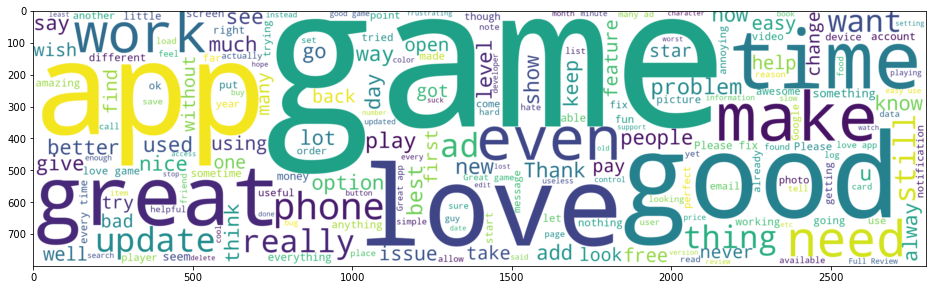

In [153]:
# per installare wordcloud, da anaconda prompt: conda install -c conda-forge wordcloud=1.8.1
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = " ".join(review for review in playstore_with_rew.Translated_Review)
print ("Ci sono {} parole nel totale delle recensioni.".format(len(text)))

wordcloud = WordCloud(  stopwords=STOPWORDS, 
                        width = 2800, height = 800,
                        background_color ='white',
                        min_font_size = 20).generate(text)

plt.figure(figsize = (16, 16), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

Notiamo che tra le piu' frequenti molte possono essere usate per un analisi sentimentale: *love, great, problem, excellent, good, better, cute, best, ...* 

Proviamo quindi a creare un metodo manuale che studi il sentimento e testiamo poi confrontandolo con le celle del nostro dataset.

## Metodo Implementato

Nel metodo utilizzo **AFINN**, che assegna ad ogni parola un punteggio che va da -5 (se è molto negativa) a +5 (se è molto positiva). 

Per la lingua inglese ci sono 2,477 parole con assegnato un punteggio.

In [154]:
# per installare afinn, da terminale pip install afinn
from afinn import Afinn
afinn = Afinn(language='en')

num_pos = 0
num_neg = 0
num_neu = 0

for review in playstore_with_rew.Translated_Review:
    
    count = 0

    words = review.split()

    for word in words:
        count += afinn.score(word)

    if count < 0:
        num_neg += 1
        
    elif count > 0:
        num_pos += 1
        
    elif count == 0:
        num_neu += 1
        
total = num_pos + num_neg + num_neu

print("\nSentimento Negativo sul Totale: " + str(num_neg/total*100) + "%")
print("Sentimento Neutrale sul Totale: " + str(num_neu/total*100) + "%")
print("Sentimento Positivo sul Totale: " + str(num_pos/total*100) + "%")

print("\nNel Dataset:")

print("Sentimento Negativo sul Totale: " + str(len(s_negative)/playstore_with_rew.shape[0]*100) + "%")
print("Sentimento Neutrale sul Totale: " + str(len(s_neutral)/playstore_with_rew.shape[0]*100) + "%")
print("Sentimento Positivo sul Totale: " + str(len(s_positive)/playstore_with_rew.shape[0]*100) + "%")


Sentimento Negativo sul Totale: 20.05065545937822%
Sentimento Neutrale sul Totale: 15.847922291185393%
Sentimento Positivo sul Totale: 64.1014222494364%

Nel Dataset:
Sentimento Negativo sul Totale: 22.28005232541958%
Sentimento Neutrale sul Totale: 13.5016282111943%
Sentimento Positivo sul Totale: 64.21831946338612%


Senza addentrarci nel confronto recensione per recensione possiamo semplicemente osservare che le distribuzioni delle percentuali dei sentimenti sono molto convincenti. 